* [accepted_2007_to_2018Q4.csv] : https://www.kaggle.com/wordsforthewise/lending-club
* [LCDataDictionary.xlsx] : https://data.world/lpetrocelli/lendingclub-loan-data-2017-q-1

#Part5. [실습2] 대출 상품 투자 위험도 줄이기

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch04. [실습2] 대출 상품 투자 위험도 줄이기" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

In [1]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [2]:
# from matplotlib import pyplot as plt
# plt.rc('font', family='NanumBarunGothic')

### 0. 데이터 불러오기

In [3]:
############################################## 00. 필요한 파이썬 라이브러리 설치하기 #####################################################
# !pip install catboost
# !pip install pandas==0.25.3

In [4]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

#### 1) 대출 승인내역 불러오기
  * issue_d 컬럼은 parse_dates 사용
  * infer_datetime_format = True
  * reset_index(drop=True) 사용

In [5]:
# !kaggle datasets download -d wordsforthewise/lending-club

In [6]:
data = pd.read_csv(
    '../3. Data/Ch 04/accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)
data.head()

c:\Users\rkfka\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

#### 2) 대출용어 사전 불러오기
  * pandas 의 read_excel 사용 / Excel Sheet 중 2번째(sheet_name=1)을 불러온다.

In [8]:
# !pip install openpyxl

In [9]:
browse_notes = pd.read_excel('../3. Data/Ch 04/대출 데이터 항목 설명.xlsx',
                            #  sheet_name=1, 
                             engine='openpyxl')
browse_notes.head()

,데이터 컬럼,설명
0,acc_now_delinq,차용인이 현재 연체 된 계정 수입니다.
1,acc_open_past_24mths,지난 24 개월 동안 열린 거래 수.
2,addr_state,대출 신청시 차용인이 제공 한 상태
3,all_util,모든 거래에 대한 신용 한도 잔액
4,annual_inc,등록 중에 차용자가 제공 한 자체보고 연간 소득입니다.


### 1. 데이터 전처리
  * 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 대출용어 사전 결측값 제거

In [10]:
browse_notes['데이터 컬럼'].dropna().values

array(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util',
       'annual_inc', 'annual_inc_joint', 'application_type',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'desc',
       'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_title',
       'fico_range_high', 'fico_range_low', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'il_util',
       'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc',
       'member_id', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
  

In [11]:
browse_feat = browse_notes['데이터 컬럼'].dropna().values
print(browse_feat)

['acc_now_delinq' 'acc_open_past_24mths' 'addr_state' 'all_util'
 'annual_inc' 'annual_inc_joint' 'application_type' 'avg_cur_bal'
 'bc_open_to_buy' 'bc_util' 'chargeoff_within_12_mths'
 'collection_recovery_fee' 'collections_12_mths_ex_med' 'delinq_2yrs'
 'delinq_amnt' 'desc' 'dti' 'dti_joint' 'earliest_cr_line' 'emp_length'
 'emp_title' 'fico_range_high' 'fico_range_low' 'funded_amnt'
 'funded_amnt_inv' 'grade' 'home_ownership' 'id' 'il_util'
 'initial_list_status' 'inq_fi' 'inq_last_12m' 'inq_last_6mths'
 'installment' 'int_rate' 'issue_d' 'last_credit_pull_d'
 'last_fico_range_high' 'last_fico_range_low' 'last_pymnt_amnt'
 'last_pymnt_d' 'loan_amnt' 'loan_status' 'max_bal_bc' 'member_id'
 'mo_sin_old_il_acct' 'mo_sin_old_rev_tl_op' 'mo_sin_rcnt_rev_tl_op'
 'mo_sin_rcnt_tl' 'mort_acc' 'mths_since_last_delinq'
 'mths_since_last_major_derog' 'mths_since_last_record'
 'mths_since_rcnt_il' 'mths_since_recent_bc' 'mths_since_recent_bc_dlq'
 'mths_since_recent_inq' 'mths_since_recent_revo

#### 2) 대출용어 사전과 대출승인 데이터 문자열 규칙 맞추기
  * 대문자, 숫자 앞에 '_' 붙여주고 모두 소문자 변환
    > re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower()
  * 공백 처리
    > .strip()

In [12]:
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]
print(browse_feat)

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'desc', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'member_id', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_

#### 3) 대출승인 데이터 컬럼과 대출용어 간의 차이를 확인한다
  * np.setdiff1d(ar1, ar2) : ar2 에는 없는 ar1의 고유한 값을 반환

In [13]:
data_feat = data.columns.values
###### 코드 작성 부분 시작 ######
np.setdiff1d(data_feat, browse_feat)
###### 코드 작성 부분 마침 ######

array(['debt_settlement_flag', 'debt_settlement_flag_date',
       'deferral_term', 'disbursement_method', 'hardship_amount',
       'hardship_dpd', 'hardship_end_date', 'hardship_flag',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'open_act_il',
       'orig_projected_additional_accrued_interest',
       'payment_plan_start_date', 'sec_app_open_act_il',
       'settlement_amount', 'settlement_date', 'settlement_percentage',
       'settlement_status', 'settlement_term',
       'verification_status_joint'], dtype=object)

In [14]:
np.setdiff1d(browse_feat, data_feat)

array(['open_il_6m', 'sec_app_open_il_6m', 'verified_status_joint'],
      dtype='<U35')

#### 4) 대출 시점(대출용어 사전)에서의 용어 중 대출승인 데이터 컬럼과 같은 의미인 용어를 서로 같게 만든다
  * 대출 시점(대출용어 사전)에서의 용어 중 대출승인 데이터 컬럼과 의미가 같지만 이름이 다른 컬럼들
          ['is_inc_v', 'mths_since_most_recent_inq','mths_since_oldest_il_open','mths_since_recent_loan_delinq', 'verified_status_joint']
  * 대출승인 데이터 컬럼에서의 이름들 (예: verified_status_join → verification_status_joint)
          ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct','mths_since_recent_bc_dlq', 'verification_status_joint']
  * np.setdiff1d / np.append 사용

In [15]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

###### 코드 작성 부분 시작 ######
browse_feat = np.setdiff1d(browse_feat, wrong)

###### 코드 작성 부분 마침 ######
browse_feat = np.append(browse_feat, correct)

#### 5) 대출용어 사전과 대출승인 데이터 컬럼 이름이 같은 것들만 가져온다.
  * np.intersect1d(ar1, ar2) : ar1 과 ar2 의 공통된 항목들만 반환한다

In [16]:
###### 코드 작성 부분 시작 ######
avail_feat = np.intersect1d(browse_feat, data_feat)
###### 코드 작성 부분 마침 ######
X = data[avail_feat].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Columns: 126 entries, acc_now_delinq to zip_code
dtypes: datetime64[ns](1), float64(101), object(24)
memory usage: 476.1+ MB


### 2. 데이터 타입별 Feature 변환
  * 결측값 처리
  * 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 범주형 데이터 확인
  * pandas 의 select_dtypes('object') 사용

In [17]:
###### 코드 작성 부분 시작 ######
cat_columns = X.select_dtypes(include = ["object", "category"]).columns
###### 코드 작성 부분 마침 ######
X[cat_columns].head()

,addr_state,application_type,desc,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,...,purpose,pymnt_plan,sec_app_earliest_cr_line,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,OK,Individual,NaN,Jan-2009,8 years,General Manager,D,RENT,130954621,w,...,other,n,NaN,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,FL,Individual,NaN,Jul-1998,2 years,IT Director,B,OWN,130964697,w,...,debt_consolidation,n,NaN,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,NH,Joint App,NaN,Jul-2007,< 1 year,Client services,G,RENT,130955326,w,...,medical,n,Feb-2005,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,AL,Individual,NaN,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,130504052,w,...,debt_consolidation,n,NaN,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,WA,Individual,NaN,Jan-1998,9 years,Scale Technician,A,RENT,130956066,w,...,major_purchase,n,NaN,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


#### 2) 범주형 문자열 데이터 중 날짜/기간/고유ID 데이터 처리
  * pandas 의 to_datetime 사용
  * .str.extract('(\d+)').astype('float') 사용

In [18]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)

In [19]:
X['earliest_cr_line'].head()

0   2009-01-01
1   1998-07-01
2   2007-07-01
3   1995-03-01
4   1998-01-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [20]:
X['emp_length'].unique()

array(['8 years', '2 years', '< 1 year', '10+ years', '9 years', nan,
       '5 years', '4 years', '1 year', '7 years', '3 years', '6 years'],
      dtype=object)

In [21]:
X['id']

0         130954621
1         130964697
2         130955326
3         130504052
4         130956066
            ...    
495237    130135401
495238    129961614
495239    130056422
495240    130065381
495241    129555354
Name: id, Length: 495242, dtype: object

In [22]:
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

In [23]:
X[['id', 'emp_length']].head()

,id,emp_length
0,130954621.0,8.0
1,130964697.0,2.0
2,130955326.0,0.0
3,130504052.0,11.0
4,130956066.0,9.0


### 3. 결측값 처리
  * 결측값 처리
  * 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 컬럼별 결측값 비율 구한 후, 비율=1 인 컬럼 제거
  * .isna().mean()
  * 컬럼별 결측값 비율이 0 인 항목을 제외한 나머지 항목들을 pandas 의 sort_values() 사용하여 정렬
  * 비율=1 인 항목을 확인하여 pandas 의 drop 으로 제거

In [24]:
t = X.isna().mean()

t[t == 1]

desc         1.0
member_id    1.0
dtype: float64

In [25]:
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

pct_tl_nvr_dlq                         0.000004
last_credit_pull_d                     0.000010
avg_cur_bal                            0.000081
all_util                               0.000260
revol_util                             0.001195
last_pymnt_d                           0.001292
dti                                    0.002286
mths_since_recent_bc                   0.012515
bc_open_to_buy                         0.013303
percent_bc_gt_75                       0.013319
bc_util                                0.013737
num_tl_120dpd_2m                       0.025046
mths_since_rcnt_il                     0.037174
mo_sin_old_il_acct                     0.037174
emp_length                             0.084781
emp_title                              0.110368
next_pymnt_d                           0.113704
mths_since_recent_inq                  0.123788
il_util                                0.163201
mths_since_last_delinq                 0.558620
mths_since_recent_revol_delinq         0

In [26]:
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

In [27]:
X.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0.0,3.0,OK,58.0,50000.0,NaN,Individual,3869.0,384.0,23.2,...,2043.690000,2043.69,824.00,0.0,1219.69,500.0,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,0.0,15.0,FL,51.0,196000.0,NaN,Individual,31468.0,7368.0,74.1,...,5301.420000,5301.42,1179.92,0.0,4121.50,52400.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,0.0,5.0,NH,84.0,44000.0,81000.0,Joint App,8397.0,632.0,66.7,...,4007.700000,4007.70,3001.43,0.0,1006.27,6200.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,0.0,2.0,AL,90.0,65000.0,NaN,Individual,10685.0,63.0,98.1,...,7511.160000,7511.16,4699.89,0.0,2811.27,8800.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,0.0,3.0,WA,1.0,52000.0,NaN,Individual,25099.0,30359.0,0.5,...,3011.577285,3011.58,11.58,0.0,3000.00,31000.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


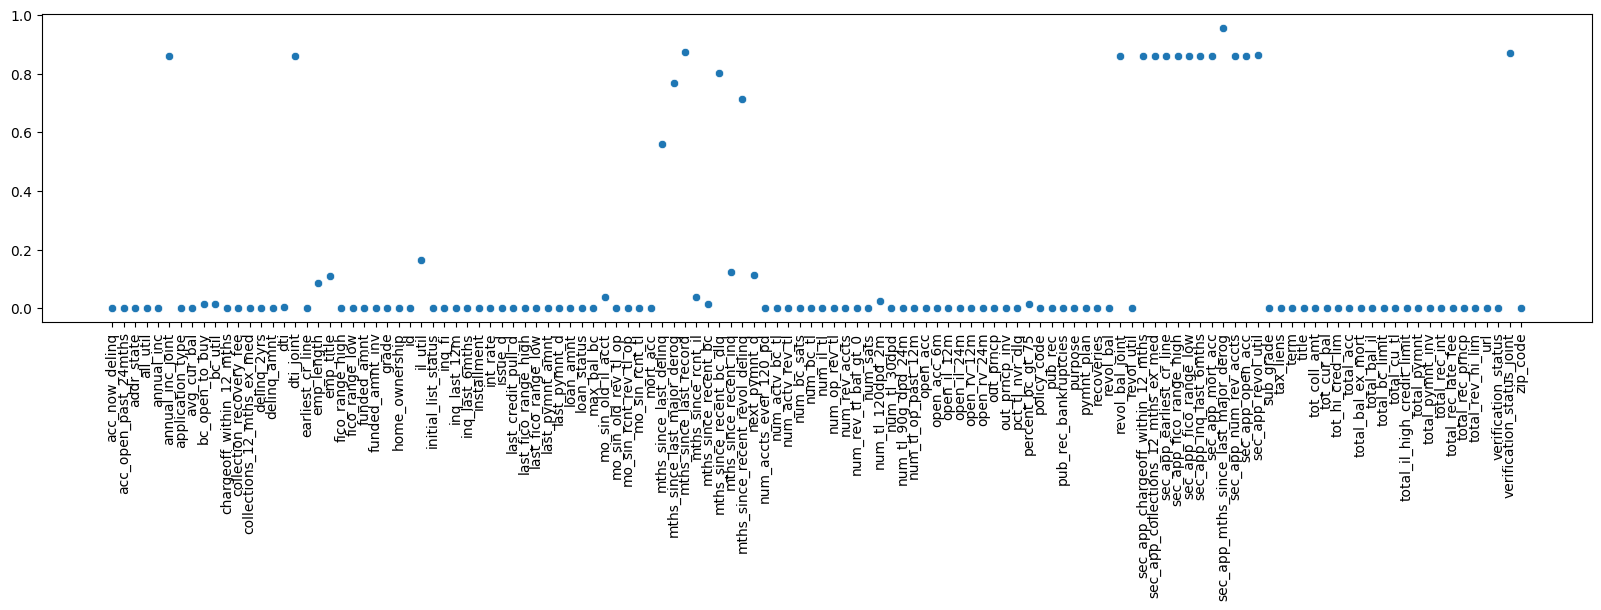

In [28]:
f = plt.figure(figsize = (20, 4))
sns.scatterplot(X.isna().mean())
plt.xticks(rotation = 90)
plt.show()

#### 2) 결측값 채우기
  * 범주형 데이터의 결측값은 공백('')으로 채운다
  * 숫자형 데이터의 결측값은 대출 데이터 특성에 따라 데이터의 최대값, 최소값으로 각각 채운다
  * 최대값으로 채우는 경우
            'bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq'
  * 최대값 이외에는 최소값으로 채운다

In [29]:
fill_empty = ['emp_title', 'verification_status_joint', 'last_pymnt_d', 'next_pymnt_d', 'sec_app_earliest_cr_line']

# 데이터 설명 시트의 빨간색 항목 참조
# 최대값으로 해서 해당 항목으로 인해 부실 대출 방향으로 판단하지 않도록 함
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']

fill_min = np.setdiff1d(X.columns.values, np.append(fill_empty, fill_max))

X[fill_empty] = X[fill_empty].fillna('')
###### 코드 작성 부분 시작 ######
X[fill_max] = X[fill_max].fillna(X[fill_max].max())
X[fill_min] = X[fill_min].fillna(X[fill_min].min())
###### 코드 작성 부분 마침 ######

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


### 4. 변수 간 상관성에 따른 데이터 정제

#### 1) 숫자형 컬럼 데이터의 유일한 값 개수 확인
  * pandas 의 select_dtypes('number') 사용
  * pandas 의 nunique().sort_values() 사용
  * 유일한 값이 1개인 경우/모든 행의 값이 다른 경우 둘 다 제거한다

In [30]:
###### 코드 작성 부분 시작 ######
num_feat = X.select_dtypes("number").columns
###### 코드 작성 부분 마침 ######

In [31]:
print(num_feat)

Index(['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       ...
       'total_bal_il', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
       'total_rev_hi_lim'],
      dtype='object', length=102)


In [32]:
X[num_feat].nunique().sort_values()

policy_code              1
num_tl_120dpd_2m         1
acc_now_delinq           2
num_tl_30dpd             2
inq_last_6mths           6
                     ...  
total_pymnt         234997
total_pymnt_inv     236121
tot_cur_bal         254794
tot_hi_cred_lim     266282
id                  495242
Length: 102, dtype: int64

In [33]:
display(X[['policy_code', 'num_tl_120dpd_2m', 'id']])

,policy_code,num_tl_120dpd_2m,id
0,1.0,0.0,130954621.0
1,1.0,0.0,130964697.0
2,1.0,0.0,130955326.0
3,1.0,0.0,130504052.0
4,1.0,0.0,130956066.0
...,...,...,...
495237,1.0,0.0,130135401.0
495238,1.0,0.0,129961614.0
495239,1.0,0.0,130056422.0
495240,1.0,0.0,130065381.0


In [34]:
X = X.drop(['policy_code', 'num_tl_120dpd_2m', 'id'], axis=1, errors='ignore')

In [35]:
X.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0.0,3.0,OK,58.0,50000.0,5693.51,Individual,3869.0,384.0,23.2,...,2043.690000,2043.69,824.00,0.0,1219.69,500.0,https://lendingclub.com/browse/loanDetail.acti...,Verified,,740xx
1,0.0,15.0,FL,51.0,196000.0,5693.51,Individual,31468.0,7368.0,74.1,...,5301.420000,5301.42,1179.92,0.0,4121.50,52400.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,,337xx
2,0.0,5.0,NH,84.0,44000.0,81000.00,Joint App,8397.0,632.0,66.7,...,4007.700000,4007.70,3001.43,0.0,1006.27,6200.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,0.0,2.0,AL,90.0,65000.0,5693.51,Individual,10685.0,63.0,98.1,...,7511.160000,7511.16,4699.89,0.0,2811.27,8800.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,,361xx
4,0.0,3.0,WA,1.0,52000.0,5693.51,Individual,25099.0,30359.0,0.5,...,3011.577285,3011.58,11.58,0.0,3000.00,31000.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,,988xx


#### 2) 숫자형 데이터 상관도에 따른 컬럼 제거
  * 숫자형 컬럼들 간 Pearson R 상관 계수를 구한다
  * 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거해 본다
  * 컬럼들 간 조합 생성 : comb_num_feat = np.array(list(combinations(num_feat, 2)))
  * Pearson R 상관 계수 구하기 : pearsonr(x1, x2)[0]

In [36]:
num_feat = X.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    ###### 코드 작성 부분 시작 ######
    corr = pearsonr(X[comb[0]], X[comb[1]])[0]
    # print(corr)
    # print(X[comb[0]], X[comb[1]])
    ###### 코드 작성 부분 마침 ######
    corr_num_feat = np.append(corr_num_feat, corr)

In [37]:
corr_num_feat

array([ 0.00059518,  0.00157713,  0.0022233 , ...,  0.02314234,
       -0.00582092,  0.15778989])

In [38]:
###### 코드 작성 부분 시작 ######
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
###### 코드 작성 부분 마침 ######
high_corr_num

array([['acc_now_delinq', 'num_tl_30dpd'],
       ['collection_recovery_fee', 'recoveries'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'funded_amnt_inv'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['funded_amnt_inv', 'installment'],
       ['funded_amnt_inv', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['last_fico_range_high', 'last_fico_range_low'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['out_prncp', 'out_prncp_inv'],
       ['sec_app_fico_range_high', 'sec_app_fico_range_low'],
       ['sec_app_num_rev_accts', 'sec_app_open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit'],
       ['total_pymnt', 'total_pymnt_inv'],
       ['total_pymnt', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_rec_prncp

In [39]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

#### 3) 범주형 데이터의 유일한 값 개수 확인
  * pandas 의 select_dtypes('object') 사용
  * pandas 의 nunique().sort_values() 사용
  * 유일한 값이 1개인 경우/모든 행의 값이 다른 경우 둘 다 제거한다
  * 범주형 데이터의 경우 Encoding 시 메모리 오류를 방지하기 위해 유일한 값이 많은 경우는 제거하는 것이 좋다

In [40]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
initial_list_status               2
pymnt_plan                        2
term                              2
verification_status               3
next_pymnt_d                      4
home_ownership                    4
verification_status_joint         4
grade                             7
loan_status                       7
title                            12
purpose                          13
last_pymnt_d                     16
last_credit_pull_d               18
sub_grade                        35
addr_state                       50
sec_app_earliest_cr_line        646
zip_code                        897
emp_title                    129450
url                          495242
dtype: int64

In [41]:
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

#### 4) 범주형 데이터 상관도에 따른 컬럼 제거
  * 범주형 컬럼들 간 카이제곱 통계량을 사용하는 Crammer 의 V 상관 계수를 구한다
  * Crammer 의 V 상관계수 식 구하는 방법


```
  table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
  corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
```


  * 상관 계수가 0.9 이상인 컬럼들 중 머신러닝 모델 생성 시 예측 변수의 조건으로 활용할 grade 를 제외한 후 가장 높은 컬럼을 제거한다.
  * 컬럼들 간 조합 생성 : comb_cat_feat = np.array(list(combinations(cat_feat, 2)))

In [42]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

In [43]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['application_type', 'sec_app_earliest_cr_line'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [44]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

### 5. 예측 변수 Feature 생성

#### 대출 상태를 보여주는 'loan_status' 를 예측 변수 Feature 로 한다
  * loan_status 의 항목별 개수를 확인한다
  * 건전한 상태를 나타내는 'Current, Fully Paid, In Grace Period' 를 1 로 나타낸다.
  * 그 외는 부실한 상태를 나타내는 0 으로 나타낸다.

In [45]:
data['loan_status'].value_counts()

Current               427181
Fully Paid             47444
Charged Off             8867
Late (31-120 days)      7221
In Grace Period         2919
Late (16-30 days)       1603
Default                    7
Name: loan_status, dtype: int64

In [46]:
y = data['loan_status'].copy()
y = y.isin(['Current', 'Fully Paid', 'In Grace Period']).astype(int)
y.value_counts()

1    477544
0     17698
Name: loan_status, dtype: int64

## 03. 모델링

#### 1) 분석 목표는 '고위험/고금리 대출 중 양호한 대출을 예측하는 것'
  * 위험도를 나타내는 grade 컬럼에서 가장 위험한 상태인 'E' 에 해당하는 데이터만 가져온다.
  * 위험도에 따라 설정되는 int_rate 컬럼은 제거한다.

In [70]:
# y.name

X_mod[y.name]

53            Current
61            Current
102           Current
110           Current
118           Current
             ...     
495066    Charged Off
495100        Current
495151        Current
495160        Current
495211        Current
Name: loan_status, Length: 18958, dtype: object

In [47]:
X_mod = X[X.grade == 'E'].copy()
X_mod = X_mod.drop(['grade', 'int_rate'], axis=1, errors='ignore')
y_mod = y[X_mod.index]

In [71]:
y_mod.name

'loan_status'

In [76]:
X_mod = X_mod.drop(["loan_status"], axis = 1, errors = "ignore")

  * 훈련 데이터와 테스트 데이터를 먼저 나눈다
  * 모델링에 사용할 훈련/검증 데이터를 그 이후에 나눈다

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

#### 2) 머신러닝 기법은 'CatBoost' 를 사용한다.
  * CatBoost 는 범주가 많은 범주형 Feature 를 포함하는 데이터셋에 매우 효율적이다.
  * CatBoost 는 범주형 데이터를 숫자형으로 변환하게 되고, 기본 설정으로 Mean Encoding 을 사용하는데 단순하게 평균을 사용하게 되면 Data Leakage 문제(우리가 예측해야 하는 값이 훈련 데이터의 Feature 에 들어가는 문제) 가 나타나게 되는데 이전 데이터들의 평균을 활용하는 방법을 사용하여 이를 해결해 준다
  * Pool 을 사용하여 학습 데이터를 CatBoost 에 맞게 변환해 준다
  * CatBoost 는 Ordered Boosting 과 Random Permutation 등의 Overfitting 을 방지하기 위한 내장 알고리즘이 있어서, 비교적 다른 Gradient Boosting 방법들에 비해 Hyper Parameter Tuning 에 자유로운 알고리즘

In [78]:
X_train.dtypes

acc_open_past_24mths    float64
addr_state               object
all_util                float64
annual_inc              float64
annual_inc_joint        float64
                         ...   
total_rec_int           float64
total_rec_late_fee      float64
total_rec_prncp         float64
total_rev_hi_lim        float64
verification_status      object
Length: 93, dtype: object

In [79]:
X_train.columns[X_train.isna().sum() > 0]

Index([], dtype='object')

In [81]:
cat_feat_ind = np.where(X_train.dtypes == "object")[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
###### 코드 작성 부분 시작 ######
# learning_rate = 0.03, verbose = False, random_state=0
model = CatBoostClassifier(learning_rate=0.03,
                           verbose=False,
                           random_state=0)
###### 코드 작성 부분 마침 ######
model.fit(pool_train, eval_set=pool_val, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### 3) 모델 평가
  * Accuracy, Precision, Recall 을 사용한다
  * Accuracy(정확도) : (실제 데이터가 예측 데이터인 수) / (전체 데이터 수) → 모델이 얼마나 정확하게 분류하는가?
  * Precision(정밀도) : (A라고 예측한 데이터가 실제 A인 데이터 수) / (A라고 예측한 데이터 수) → 모델이 찾은 A는 얼마나 정확한가? "일반 메일을 스팸 메일로 분류해서는 안된다"
  * Recall(재현율) : (A라고 예측한 데이터 수) / (실제 A인 데이터 수) → 모델이 얼마나 정확하게 A를 찾는가? "실제 암환자인 경우 반드시 양성으로 판단해야 한다"

Accuracy (test): 0.984
Precision (test): 0.983
Recall (test): 0.999


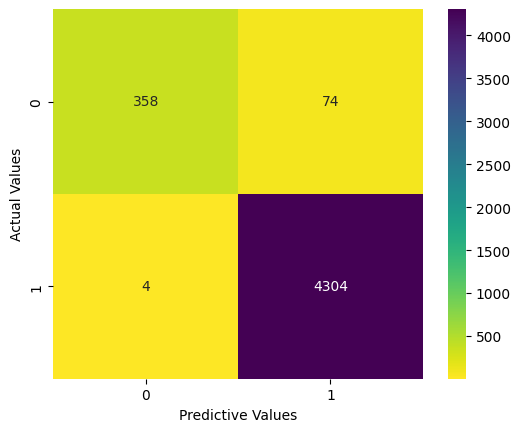

In [82]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

###### 코드 작성 부분 시작 ######
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
###### 코드 작성 부분 마침 ######
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predictive Values')
ax.set_ylabel('Actual Values');

## 04. Feature Importances

#### 1) Feature Importances 그래프 그리기

In [83]:
model.feature_importances_

array([3.91043558e-01, 2.98210803e-01, 1.75915390e-01, 5.29263225e-01,
       2.54067912e-02, 1.69205635e-02, 1.82081779e-01, 7.47341714e-01,
       3.63980787e-01, 5.91929178e-02, 9.84460973e-03, 3.78122723e-02,
       1.60618584e-02, 2.06491980e-01, 4.86187882e-02, 5.58029343e-01,
       1.75842648e-01, 4.84475582e-01, 1.74357200e-01, 2.00323868e-01,
       2.79656208e-01, 3.73897757e-01, 1.88705139e-01, 2.24903869e-01,
       8.44706269e-01, 1.16158441e-01, 9.54739620e+00, 2.99965964e+00,
       3.21004772e+01, 4.87506770e+00, 5.93432671e-01, 5.25048138e-01,
       2.10111079e-01, 1.46865434e-01, 5.76259381e-02, 1.85256579e-01,
       5.73170891e-02, 2.16177636e-01, 5.24916505e-01, 7.69634932e-01,
       3.11514303e-01, 5.07735051e-01, 1.31565796e-01, 4.65113118e+00,
       3.90985298e-01, 2.08730517e-01, 2.43599820e-01, 8.67733934e-02,
       2.59610903e-01, 3.51409196e-01, 4.42200058e-01, 2.23734957e-01,
       0.00000000e+00, 9.29346021e-04, 5.27562801e-01, 3.56216274e-01,
      

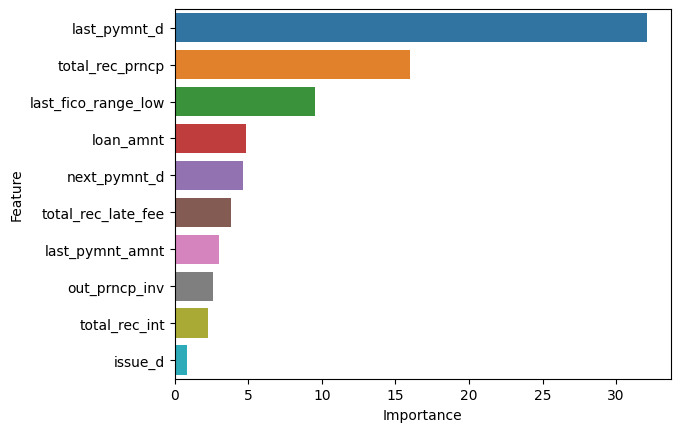

In [84]:
feat = model.feature_names_
###### 코드 작성 부분 시작 ######
imp = model.feature_importances_
###### 코드 작성 부분 마침 ######
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

#### 2) 주요 3개 Feature 와 건전/부실 대출 간 관계

* 대출액 히스토그램 상에서의 건전/부실 대출

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


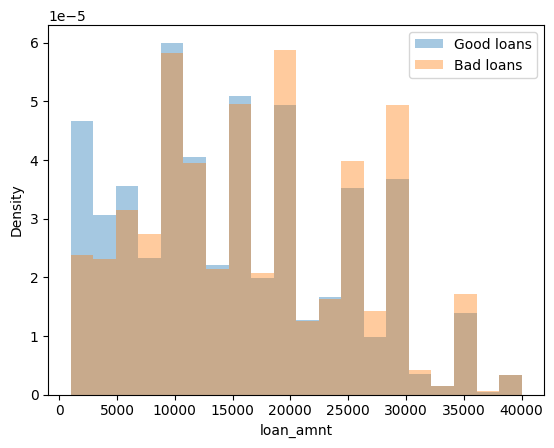

In [85]:
good = X_mod.loc[y_mod == 1, 'loan_amnt']
bad = X_mod.loc[y_mod == 0, 'loan_amnt']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

* 가장 최근에 대출 문의한 기간 히스토그램 상에서의 건전/부실 대출

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


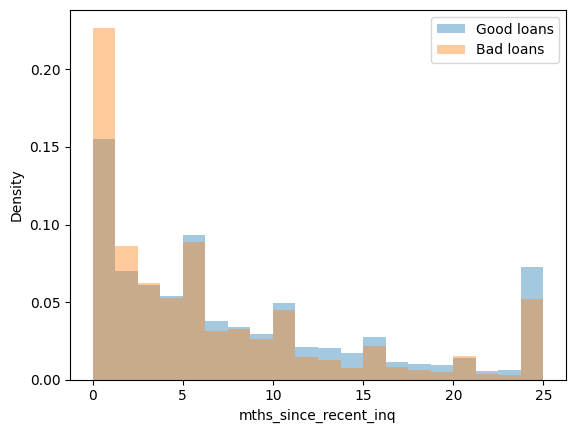

In [87]:
good = X_mod.loc[y_mod == 1, 'mths_since_recent_inq']
bad = X_mod.loc[y_mod == 0, 'mths_since_recent_inq']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


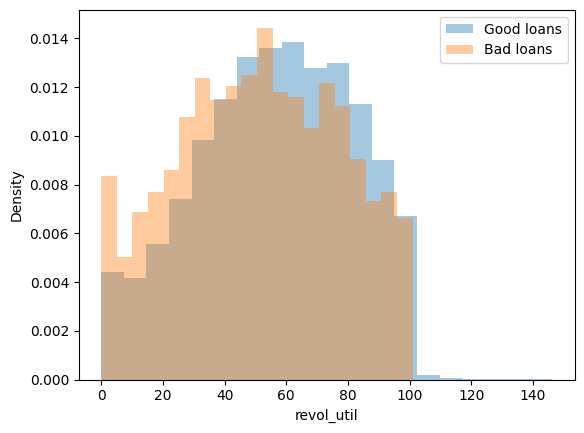

In [59]:
good = X_mod.loc[y_mod == 1, 'revol_util']
bad = X_mod.loc[y_mod == 0, 'revol_util']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();